Q: How much more likely is certain preexisting conditions/symptoms to be related to high mortality? 

In [2]:
# Import dependencies 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn import tree

# Database 
import psycopg2
import config as creds

In [3]:
# Connecting to database 
conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
                  +" password="+ creds.PGPASSWORD
conn = psycopg2.connect(conn_string)

In [4]:
covid_df = pd.read_sql_query(
                   ''' SELECT * FROM coviddata 
                   ''' , conn)

In [5]:
covid_df;

In [7]:
# Drop header row 
covid_df = covid_df.iloc[1:]


In [9]:
# Grabbing relevant column names that contribute to covid risk factors 
column_names = ['meanage','male','smoking', 'hypertension', 'diabetes', 'cardiovasculardisease',
                'lungdisease', 'cancer', 'liverdisease', 'cerebrovasculardisease',
                'chronickidneydisease', 'otherconditions', 'fever', 'tachypnea',
                'cough', 'shortofbreath', 'headache', 'sputum', 'muscleaches',
                'fatigue', 'upperairwaycongestion', 'diarrhea', 'nauseavomiting', 'appetiteloss',
                'sorethroatstuffynose', 'chills', 'chest_pain', 'smelltasteloss', 'nosymptoms',
                'mortality_bin']

new_df = covid_df[column_names]
new_df;

In [11]:
# Convert string to floats 
new_df=new_df.astype(str).astype(float)

In [12]:
# Rename column
new_df = new_df.rename(columns={"mortality_bin": "Mortality_bin"})

In [13]:
# Assigning variables for Classifier Modeling
data = new_df.drop("Mortality_bin", axis=1)
feature_names = data.columns
target=new_df['Mortality_bin']
target_names=['low_risk','high_risk']

In [14]:
# Split test/train data 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=1)

In [15]:
# Decision tree classifier returns 100% 
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)  
clf.score(X_test, y_test)

1.0

In [16]:
# Decision random forest classifier also returns 100% 
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

1.0

In [17]:
# Looking at feature importances
sorted(zip(rf.feature_importances_, feature_names), reverse=True) 

[(0.18319779906000747, 'diabetes'),
 (0.08065168026916218, 'hypertension'),
 (0.07596551410234265, 'chronickidneydisease'),
 (0.07312948304937791, 'meanage'),
 (0.07095129723320824, 'lungdisease'),
 (0.06487135061714323, 'cardiovasculardisease'),
 (0.04702196224443452, 'cancer'),
 (0.04648069087787865, 'male'),
 (0.04455780610954689, 'shortofbreath'),
 (0.03860893527582657, 'fever'),
 (0.03029291412230008, 'tachypnea'),
 (0.030010713763954516, 'cerebrovasculardisease'),
 (0.028858513751823998, 'cough'),
 (0.027176414314479688, 'diarrhea'),
 (0.024780884884134446, 'muscleaches'),
 (0.023449535786043016, 'fatigue'),
 (0.014511883881708211, 'nauseavomiting'),
 (0.014216335459847799, 'otherconditions'),
 (0.014158199514179624, 'smoking'),
 (0.013228345721836812, 'liverdisease'),
 (0.013014298005028943, 'sputum'),
 (0.011652447740000037, 'headache'),
 (0.009769621507072335, 'sorethroatstuffynose'),
 (0.00938126495711403, 'chest_pain'),
 (0.006050378836654203, 'appetiteloss'),
 (0.0019019079

In [20]:
# Grabbing top 6 underlying illness and symptoms and age/gender as factors based on feature importance
column_names = ['meanage','male','hypertension', 'diabetes', 'cardiovasculardisease',
                'lungdisease', 'cancer', 'chronickidneydisease', 'fever', 'tachypnea',
                'cough', 'shortofbreath',  'diarrhea',
                'fatigue',
                'Mortality_bin']
factors = pd.DataFrame(new_df,columns=column_names)
factors;


In [21]:
# Assigning variables for logistic regression 
X = factors.drop('Mortality_bin', axis=1)
y = factors['Mortality_bin']

# Split test/train data to 80% train for optimize model score 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=.80, random_state=1)


In [22]:
# Importing logistic regression 
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=300)
classifier


LogisticRegression(max_iter=300)

In [23]:
# Fit training data 
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=300)

In [24]:
# Logistic Regression model score 
print(f"Training Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.875


In [25]:
# Using classifier for predictions
predictions = classifier.predict(X_test)
result=pd.DataFrame({"Prediction": predictions, "Actual": y_test}).head(25)
result;

In [26]:
# Printing f-score in classification report 
from sklearn.metrics import classification_report
print(classification_report (y_test, predictions, target_names = ['low risk','high risk']))

              precision    recall  f1-score   support

    low risk       0.92      0.93      0.92       188
   high risk       0.67      0.66      0.67        44

    accuracy                           0.88       232
   macro avg       0.80      0.79      0.79       232
weighted avg       0.87      0.88      0.87       232



In [27]:
# Printing classification report as csv file 
report = classification_report (y_test, predictions, target_names = ['low risk','high risk'],output_dict=True)
class_report=pd.DataFrame(report).transpose()
class_report
# class_report.to_csv('../static/pltImages/classificationReport.csv')

precision    recall  f1-score  support
low risk       0.920635  0.925532  0.923077  188.000
high risk      0.674419  0.659091  0.666667   44.000
accuracy       0.875000  0.875000  0.875000    0.875
macro avg      0.797527  0.792311  0.794872  232.000
weighted avg   0.873939  0.875000  0.874447  232.000

In [28]:
# Import sklearn for confusion matrix 
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, predictions, labels = [0,1])
matrix

array([[174,  14],
       [ 15,  29]])

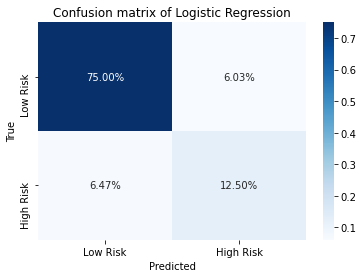

In [29]:
# Visualize confusion matrix with % break down 
import seaborn as sns
ax = plt.subplot()
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%', cmap='Blues', ax=ax)
ax.set_title('Confusion matrix of Logistic Regression')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.xaxis.set_ticklabels(['Low Risk','High Risk']); ax.yaxis.set_ticklabels(['Low Risk','High Risk']);

plt.savefig('../static/pltImages/confusionMatrix.png');


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

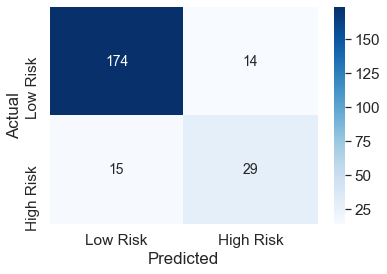

In [30]:
# Visualize confusion matrix with values (alternate choice)
labels = ['Low Risk','High Risk']
data = confusion_matrix(y_test,predictions)
data_df = pd.DataFrame(data, columns=labels, index = labels)
data_df.index.name = 'Actual'
data_df.columns.name = 'Predicted'
# plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(data_df, cmap="Blues", annot=True, fmt='g',annot_kws={"size": 14})# font size

Test risk calculator 

In [31]:
list(factors)

['meanage',
 'male',
 'hypertension',
 'diabetes',
 'cardiovasculardisease',
 'lungdisease',
 'cancer',
 'chronickidneydisease',
 'fever',
 'tachypnea',
 'cough',
 'shortofbreath',
 'diarrhea',
 'fatigue',
 'Mortality_bin']

In [32]:
# Testing new patient data 
new_patient = [26,1,0,1,0,0,0,0,1,0,0,0,0,0]


In [33]:
# Inputting new patient data for prediction
data = np.array([new_patient]) 
predictions = classifier.predict(data)
predictions

array([1.])

In [34]:
# Saving model to file 
import pickle
filename='../LogisticRegression/predictorRisk2.sav'
pickle.dump(classifier, open(filename,'wb'))